In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from pyspark import SparkContext
from google.colab import drive
sc = SparkContext.getOrCreate()
drive.mount('/content/mydrive', force_remount=True)

Mounted at /content/mydrive


In [2]:
DATAFILE_PATTERN = '^(.+),"(.+)",(.*),(.*),(.*)'
def remove_quotes(s):
    return ''.join(i for i in s if i != '"')

In [3]:
def parse_data_file_line(data_file_line):
    match = re.search(DATAFILE_PATTERN, data_file_line)
    if match is None:
        print('Invalid datafile line: %s' % data_file_line)
        return (data_file_line, -1)
    elif match.group(1) == '"id"':
        print('Header datafile line: %s' % data_file_line)
        return (data_file_line, 0)
    else:
        product = '%s %s %s' % (match.group(2), match.group(3), match.group(4))
        return ((remove_quotes(match.group(1)), product), 1)

In [4]:
files = {
  'Amazon':                 "/content/mydrive/My Drive/CSCI-573/Amazon.csv"
, 'Google':                 "/content/mydrive/My Drive/CSCI-573/Google.csv"
, 'stopwords':              "/content/mydrive/My Drive/CSCI-573/stopwords.txt"
, 'gold_standard':          "/content/mydrive/My Drive/CSCI-573/Amazon_Google_perfectMapping.csv"
}

In [5]:
def parse_data(filename):
    return sc.textFile(filename, 4, use_unicode=True).map(parse_data_file_line)

In [6]:
def load_data(filekey):
    raw = parse_data(files[filekey]).cache()
    failed = raw.filter(lambda s: s[1] == -1).map(lambda s: s[0])
    for line in failed.take(10):
        print('%s - Invalid datafile line: %s' % (files[filekey], line))
    valid = raw.filter(lambda s: s[1] == 1).map(lambda s: s[0]).cache()
    print('%s - Read %d lines, successfully parsed %d lines, failed to parse %d lines'
        % (files[filekey], raw.count(), valid.count(), failed.count()))
    assert(failed.count() == 0)
    assert(raw.count() == (valid.count() + 1))
    return valid

In [7]:
google = load_data('Google')
amazon = load_data('Amazon')

/content/mydrive/My Drive/CSCI-573/Google.csv - Read 3227 lines, successfully parsed 3226 lines, failed to parse 0 lines
/content/mydrive/My Drive/CSCI-573/Amazon.csv - Read 1364 lines, successfully parsed 1363 lines, failed to parse 0 lines


In [8]:
# (1a) Tokenize a string
# (1b) Removing stopwords
split_regex = r'\W+'
stopwords = set(sc.textFile(files['stopwords'], 1, use_unicode=True).collect())

def tokenize(string):
    return [w for w in re.split(split_regex, string.lower())
               if w != '' and w not in stopwords]

In [9]:
# (4a) Tokenize the full dataset
amazon_full_rec_to_token = amazon.map(lambda line: (line[0], tokenize(line[1])))
google_full_rec_to_token = google.map(lambda line: (line[0], tokenize(line[1])))
print('Amazon full dataset is %s products, Google full dataset is %s products'
    % (amazon_full_rec_to_token.count(), google_full_rec_to_token.count()))
# Amazon full dataset is 1363 products, Google full dataset is 3226 products

Amazon full dataset is 1363 products, Google full dataset is 3226 products


In [10]:
# (2a) Implement a TF Function
def tf(tokens):
    TF = dict()
    for token in tokens:
        if token not in TF:
            TF[token] = 1
        else: TF[token] += 1
    for token in TF:
        TF[token] = TF[token] / len(tokens)
    return TF

In [11]:
# (2c) Implement an IDFs Function
def idfs(corpus):
    N = corpus.count()
    unique_tokens = corpus.map(lambda x: {t for t in x[1]})
    token_count_pair_tuple = unique_tokens.flatMap(lambda s: [(t, 1) for t in s])
    token_sum_pair_tuple = token_count_pair_tuple.reduceByKey(lambda total, count: total + count);
    return token_sum_pair_tuple.map(lambda x: (x[0], N / x[1]))

In [12]:
# (2f) Implement a TF-IDF Function
def tfidf(tokens, idfs):
    tfs = tf(tokens)
    tf_idf_dict = {t: TF * idfs[t] for t, TF in tfs.items()}
    return tf_idf_dict

In [13]:
# (4b) Compute IDFs and TF-IDFs for the full datasets
RDD_full_corpus = amazon_full_rec_to_token.union(google_full_rec_to_token)
idfs_full = idfs(RDD_full_corpus)
idfs_full_count = idfs_full.count()
print('There are %s unique tokens in the full datasets.' % idfs_full_count)
# There are 17078 unique tokens in the full datasets.
# Recompute IDFs for full dataset
idfs_full_weights = idfs_full.collectAsMap()
idfs_full_broadcast = sc.broadcast(idfs_full_weights)
# Pre-compute TF-IDF weights. Build mappings from record ID weight vector.
RDD_amazon_weights = amazon_full_rec_to_token.map(lambda x: (x[0], tfidf(x[1], idfs_full_weights)))
RDD_google_weights = google_full_rec_to_token.map(lambda x: (x[0], tfidf(x[1], idfs_full_weights)))
print('There are %s Amazon weights and %s Google weights.'
      % (RDD_amazon_weights.count(), RDD_google_weights.count()))
# There are 1363 Amazon weights and 3226 Google weights.

There are 17078 unique tokens in the full datasets.
There are 1363 Amazon weights and 3226 Google weights.


In [14]:
import math
def dotprod(a, b):
    sum = 0.0
    for t, at in a.items():
        if t in b:
            sum += at * b[t]
    return sum
def norm(a):
    sum = 0.0
    for t, at in a.items():
        sum += at * at
    return math.sqrt(sum)
def cossim(a, b):
    return dotprod(a, b) / (norm(a) * norm(b))

In [15]:
# (4c) Compute Norms for the weights from the full datasets
amazon_norms = RDD_amazon_weights.map(lambda x: (x[0], norm(x[1]))).collectAsMap()
amazon_norms_broadcast = sc.broadcast(amazon_norms)
google_norms = RDD_google_weights.map(lambda x: (x[0], norm(x[1]))).collectAsMap()
google_norms_broadcast = sc.broadcast(google_norms)
print(len(amazon_norms_broadcast.value))
#1363
print(len(google_norms_broadcast.value))
#3226

1363
3226


In [16]:
# (4d) Create inverted indicies from the full datasets
def invert(record):
    return [(k, record[0]) for k in record[1].keys()]
print(invert((1, {'foo': 2, 'bar': 3})))
#[('foo', 1), ('bar', 1)]
RDD_amazon_inv_pairs = RDD_amazon_weights.flatMap(lambda x: invert(x)).cache()
RDD_google_inv_pairs = RDD_google_weights.flatMap(lambda x: invert(x)).cache()
print('There are %s Amazon inverted pairs and %s Google inverted pairs.'
     % (RDD_amazon_inv_pairs.count(), RDD_google_inv_pairs.count()))
#There are 111387 Amazon inverted pairs and 77678 Google inverted pairs.

[('foo', 1), ('bar', 1)]
There are 111387 Amazon inverted pairs and 77678 Google inverted pairs.


In [17]:
# (4e) Identify common tokens from the full dataset
from pyspark.rdd import portable_hash
def swap(record): return (record[1], record[0])
common_tokens = ( RDD_amazon_inv_pairs #.partitionBy(64, lambda k: portable_hash(k[0]))
                  .join(RDD_google_inv_pairs) #.partitionBy(64, lambda k: portable_hash(k[0]))
                  .map(lambda x: swap(x))
                  .groupByKey()
                  .cache()
                )
print('Found %d common tokens' % common_tokens.count())
#Found 2441100 common tokens

Found 2441100 common tokens


In [18]:
# (4f) Identify common tokens from the full dataset (cont.)
amazon_weights_broadcast = sc.broadcast(RDD_amazon_weights.collectAsMap())
google_weights_broadcast = sc.broadcast(RDD_google_weights.collectAsMap())
def fast_cosine_similarity(record):
    amazon_rec = record[0][0]
    google_rec = record[0][1]
    tokens = record[1]
    value = 0.0
    for token in tokens:
        value +=  ( amazon_weights_broadcast.value[amazon_rec][token]
                  * google_weights_broadcast.value[google_rec][token]
                  )
    value /= amazon_norms_broadcast.value[amazon_rec]
    value /= google_norms_broadcast.value[google_rec]
    key = (amazon_rec, google_rec)
    return (key, value)
RDD_similarities_full = common_tokens.map(lambda x: fast_cosine_similarity(x)).cache()
pprint(RDD_similarities_full.count())
#2441100
similarity_test = RDD_similarities_full.filter(
    lambda x: x[0][0] == 'b00005lzly'
          and x[0][1] == 'http://www.google.com/base/feeds/snippets/13823221823254120257'
).collect()
pprint(similarity_test)
#[(('b00005lzly', 'http://www.google.com/base/feeds/snippets/13823221823254120257'), 4.286548413995203e-06)]

2441100
[(('b00005lzly',
   'http://www.google.com/base/feeds/snippets/13823221823254120257'),
  4.2865484139952024e-06)]


In [19]:
# (3e) Perform a Gold Standard Evaluation
GOLDFILE_PATTERN = '^(.+),(.+)'
def parse_goldfile_line(goldfile_line):
    match = re.search(GOLDFILE_PATTERN, goldfile_line)
    if match is None:
        print('Invalid goldfile line: %s' % goldfile_line)
        return (goldfile_line, -1)
    elif match.group(1) == '"idAmazon"':
        print('Header datafile line: %s' % goldfile_line)
        return (goldfile_line, 0)
    else:
        key = '%s %s' % (remove_quotes(match.group(1)), remove_quotes(match.group(2)))
        return ((key, 'gold'), 1)

goldfile = files['gold_standard']
gs_raw = sc.textFile(goldfile).map(parse_goldfile_line).cache()
gs_failed = gs_raw.filter(lambda s: s[1] == -1).map(lambda s: s[0])
for line in gs_failed.take(10):
    print('Invalid goldfile line: %s' % line)
gold_standard = gs_raw.filter(lambda s: s[1] == 1).map(lambda s: s[0]).cache()
print('Read %d lines, successfully parsed %d lines, failed to parse %d lines'
     % (gs_raw.count(), gold_standard.count(),  gs_failed.count()))
assert (gs_failed.count() == 0)
assert (gs_raw.count() == (gold_standard.count() + 1))
#Read 1301 lines, successfully parsed 1300 lines, failed to parse 0 lines

Read 1301 lines, successfully parsed 1300 lines, failed to parse 0 lines


In [20]:
# (5a) Counting True Positives, False Positives, and False Negatives
RDD_sims_full = RDD_similarities_full.map(lambda x: ("%s %s" % (x[0][0], x[0][1]), x[1]))
assert RDD_sims_full.count() == 2441100
RDD_sims_full_values = RDD_sims_full.map(lambda x: x[1]).cache()
assert RDD_sims_full_values.count() == 2441100
def gs_value(record): return record[1][1] if record[1][1] else 0
RDD_true_dup_sims = gold_standard.leftOuterJoin(RDD_sims_full).map(gs_value).cache()
print('There are %s true duplicates.' % RDD_true_dup_sims.count())
#There are 1300 true duplicates.
assert RDD_true_dup_sims.count() == 1300

There are 1300 true duplicates.


In [21]:
from pyspark.accumulators import AccumulatorParam
class VectorAccumulatorParam(AccumulatorParam):
    def zero(self, value): return [0] * len(value)
    def addInPlace(self, v1, v2):
        for i in range(len(v1)):
            v1[i] += v2[i]
        return v1

def set_bit(x, value, length):
    bits = []
    for y in range(length):
        if (x == y): bits.append(value)
        else: bits.append(0)
    return bits

BINS = 101
n_thresholds = 100
def bin(similarity):
    return int(similarity * n_thresholds)

zeros = [0] * BINS
fp_counts = sc.accumulator(zeros, VectorAccumulatorParam())

def add_element(score):
    global fp_counts
    b = bin(score)
    fp_counts += set_bit(b, 1, BINS)

RDD_sims_full_values.foreach(add_element)

def sub_element(score):
    global fp_counts
    b = bin(score)
    fp_counts += set_bit(b, -1, BINS)

RDD_true_dup_sims.foreach(sub_element)

def false_pos(threshold):
    fp_list = fp_counts.value
    return sum([fp_list[b] for b in range(0, BINS) if float(b) / n_thresholds >= threshold])

def false_neg(threshold):
    return RDD_true_dup_sims.filter(lambda x: x < threshold).count()

def true_pos(threshold):
    return RDD_true_dup_sims.count() - false_neg_dict[threshold]

In [22]:
# (5b) Precision, Recall, and F-measures
# Precision = true_positives / (true_positives + false_positives)
# Recall = true_positives / (true_positives + false_negatives)
# F-measure = 2 x Recall x Precision / (Recall + Precision)
def precision(threshold):
    tp = true_pos_dict[threshold]
    return float(tp) / (tp + false_pos_dict[threshold])
def recall(threshold):
    tp = true_pos_dict[threshold]
    return float(tp) / (tp + false_neg_dict[threshold])
def fmeasure(threshold):
    r = recall(threshold)
    p = precision(threshold)
    return 2 * r * p / (r + p)

0.0005325468026709271 0.0010645266950540452


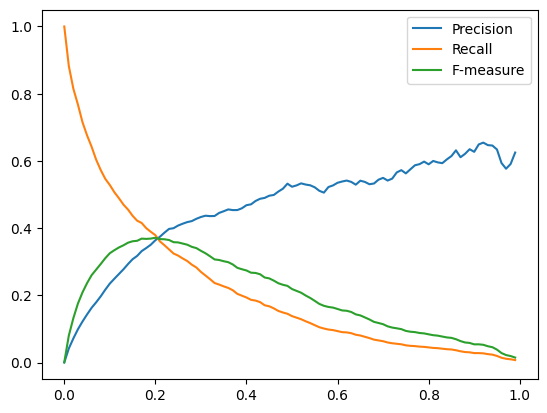

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


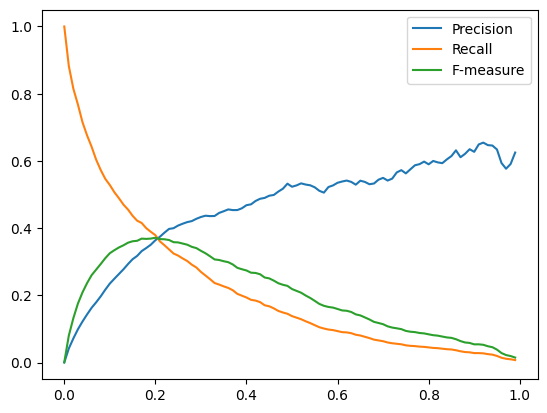

In [23]:
# (5c) Line Plots
thresholds = [float(n) / n_thresholds for n in range(0, n_thresholds)]
false_pos_dict = dict([(t, false_pos(t)) for t in thresholds])
false_neg_dict = dict([(t, false_neg(t)) for t in thresholds])
true_pos_dict = dict([(t, true_pos(t)) for t in thresholds])
precisions = [precision(t) for t in thresholds]
recalls = [recall(t) for t in thresholds]
fmeasures = [fmeasure(t) for t in thresholds]
print(precisions[0], fmeasures[0])
#0.0005325468026709271 0.0010645266950540452
assert abs(precisions[0] - 0.000532546802671) < 0.0000001
assert abs(fmeasures[0] - 0.00106452669505) < 0.0000001
fig = plt.figure()
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, fmeasures)
plt.legend(['Precision', 'Recall', 'F-measure'])
display(fig)
pass
from pyspark.sql import Row
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
graph = [(t, precision(t), recall(t), fmeasure(t)) for t in thresholds]
RDD_graph = sc.parallelize(graph)
row_graph = RDD_graph.map(lambda txyz: Row(threshold=txyz[0], precision=txyz[1], recall=txyz[2], fmeasure=txyz[3]))
DF_graph = sqlContext.createDataFrame(row_graph)
display(DF_graph)

(5d) Discussion

State-of-the-art tools can get an F-measure of about 60% on this dataset. In this assignment, our
best F-measure is closer to 40%. Look at some examples of errors (both False Positives and False
Negatives) and think about what went wrong. There are several ways we might improve our simple
classifier, including:

* Using additional attributes
* Performing better featurization of our textual data (e.g., stemming, n-grams, etc.)
* Using different similarity functions